# Collaboration and Competition

Here is my solution to the third project of the udacity deep reinforcement learning nanodegree.

The goal of this project is training agents to play tennis. 

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import time
import numpy as np
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from agent import Agent
from replay_buffer import ReplayBuffer

The following cells load the tennis environment and describe the environment

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")
#env = env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain)

Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1,5):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [1]:
agent1 = Agent(state_size=state_size,action_size=action_size)

agent2 = Agent(state_size=state_size,action_size=action_size,memory=agent1.memory) # Sharing replay memory between ddpg agents.

NameError: name 'Agent' is not defined

In [7]:
target_score=0.5
scores_max_hist = []
scores_mean_hist = []
env_info = env.reset(train_mode=True)[brain_name]
def ddpg(n_episodes=2550, print_every=100):
    start_time = time.time()            #just grabbing the start time
    scores_deque = deque(maxlen=print_every)
    scores = []
    best_score = 0.0
    noise = True
    for i_episode in range(1, n_episodes+1):
        if i_episode > 300:
            noise = False
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent1.reset()
        agent2.reset()
        scores_ep = np.zeros(num_agents)
        while True:
            action1 = agent1.act(states[0], add_noise=noise).tolist()
            action2 = agent2.act(states[1], add_noise=noise).tolist()
            actions = [action1, action2]
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent1.step(states[0], action1, rewards[0], next_states[0], dones[0])
            agent2.step(states[1], action2, rewards[1], next_states[1], dones[1])
            scores_ep += rewards
            states = next_states
            if np.any(dones):
                break
        max_score = np.max(scores_ep)
        scores_deque.append(max_score)
        score_mean = np.mean(scores_deque)
        scores.append(max_score)
        scores_max_hist.append(max_score)
        scores_mean_hist.append(score_mean)
        
        if max_score > best_score:
            best_score = max_score
        elapsed_time = time.time() - start_time        
        print('\rEpisode {}\tAverage Score: {:.2f} \tbest_score {}\t Elapsed Time:{}sec'.format(i_episode, np.mean(scores_deque), best_score,round(elapsed_time)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= target_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1d.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1d.pth')
            torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor2d.pth')
            torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic2d.pth')
            print("\nEnviroment is solved in {} sec",round(elapsed_time))
            break
    return scores

In [8]:
scores = ddpg()

Episode 100	Average Score: 0.00 	best_score 0.09000000171363354	 Elapsed Time:33sec
Episode 200	Average Score: 0.00 	best_score 0.09000000171363354	 Elapsed Time:65sec
Episode 300	Average Score: 0.00 	best_score 0.09000000171363354	 Elapsed Time:97sec
Episode 400	Average Score: 0.00 	best_score 0.09000000171363354	 Elapsed Time:129sec
Episode 500	Average Score: 0.00 	best_score 0.09000000171363354	 Elapsed Time:162sec
Episode 600	Average Score: 0.00 	best_score 0.10000000149011612	 Elapsed Time:196sec
Episode 700	Average Score: 0.02 	best_score 0.20000000298023224	 Elapsed Time:240sec
Episode 800	Average Score: 0.03 	best_score 0.20000000298023224	 Elapsed Time:286sec
Episode 900	Average Score: 0.05 	best_score 0.20000000298023224	 Elapsed Time:343sec
Episode 1000	Average Score: 0.12 	best_score 0.4000000059604645	 Elapsed Time:463sec
Episode 1082	Average Score: 0.51 	best_score 2.600000038743019	 Elapsed Time:905secc
Environment solved in 1082 episodes!	Average Score: 0.51

Enviroment

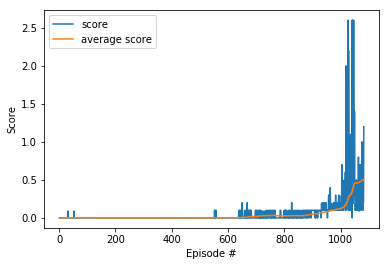

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(np.arange(1, len(scores_max_hist)+1), scores_max_hist, label='score')
plt.plot(np.arange(1, len(scores_mean_hist)+1), scores_mean_hist, label='average score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.savefig("score")
plt.show()

In [11]:
env.close()

## Future Improvements
I've seen suggestions that others have had success with similar problems using using a Proximal Policy Optimization algorithm instead ddpg.

Another thing I'd like to train is share more information between agents. For example having the actor networks sync weights (I was thinking throught averaging them) after a certain amount of episodes. 